## Описание проекта

Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.


## Цели проекта

- Подготовить данные для обучения модели;
- Построить модель предсказывающую рейтинг ресторана.

## Загрузка дополнительных библиотек:

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import datetime
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import re 

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42

In [3]:
# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > data/requirements.txt

## Загрузка данных

In [4]:
df_train = pd.read_csv('data/main_task.csv')
df_test = pd.read_csv('data/kaggle_task.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [5]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на [TripAdvosor](https://www.tripadvisor.com/);
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Предварительный просмотр данных

### Типы признаков

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Числовой формат данных имеют три признака: 'Ranking', 'Rating', 'Number of Reviews'.

Признаки 'Cuisine Style', 'Reviews' имеют строковый тип данных, при этом содержат в себе список значений.

### Пропуски в данных

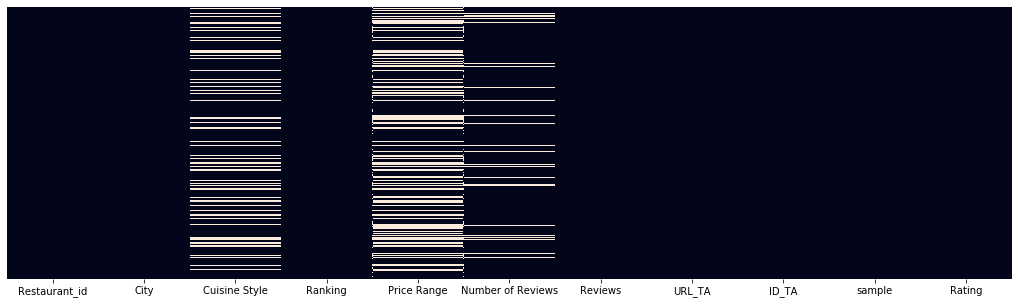

In [8]:
fig, ax = plt.subplots(figsize=(18, 5))
sns_heatmap = sns.heatmap(
    data.isnull(), yticklabels=False, cbar=False)

Признаки 'Cuisine Style', 'Price Range', 'Number of Reviews' имеют пропуски в данных.

### Распределение целевой переменной


Text(0.5, 1.0, 'test data')

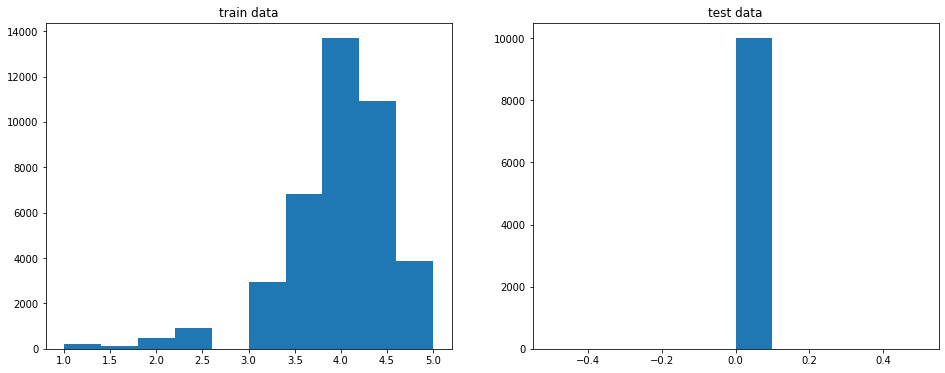

In [9]:
plt.figure(figsize = (16, 6))

plt.subplot(1,2,1)
plt.hist(df_train['Rating'])
plt.title('train data')

plt.subplot(1,2,2)
plt.hist(df_test['Rating'])
plt.title('test data')

В трейне оценки распределены на интервале от 1 до 5 с шагом 0.5, а тест целиком состоит из нулевых значений

## Очистка и подготовка данных

### 1. Обработка NAN

Сохраним данные о наличии пропусков в отдельные признаки:

In [10]:
data['cuisine_style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['price_range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['number_of_reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

### 2. Обработка признаков

#### Restaurant_id

Данный признак не несет никакой полезной для построения модели информации

#### City

Проведем ранговую трансформацию по параметру 'City' и добавим новый признак 'ranked_cities':

In [11]:
data['ranked_cities'] = data['City'].rank()

Узнаем количество уникальных значений в параметре 'City' и посмотрим количество ресторанов в каждом городе:

In [12]:
data['City'].nunique()

31

In [13]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

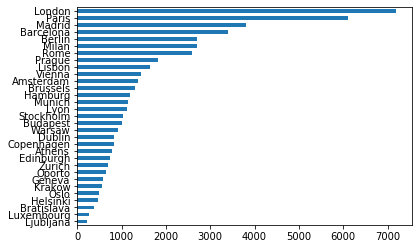

In [14]:
data['City'].value_counts(ascending=True).plot(kind='barh')

Создадим признак rest_counts - отображающий кол-во ресторанов в городе

In [15]:
data['rest_counts'] = data['City'].apply(lambda x: data['City'].value_counts()[x])

Добавим признак распределения отзывов о ресторанах по городам:

In [16]:
data['reviews_in_city'] = data['City'].apply(lambda x: data.groupby(['City'])\
                                              ['Number of Reviews'].sum().sort_values(ascending=False)[x])

Добавим признак с численностью населения по городам в миллионах человек:

In [17]:
population = {'London': 8.982,'Paris': 2.148, 'Madrid': 6.642, 'Berlin': 3.769,  'Rome':2.873 , 'Prague': 1.309,
              'Lisbon': 0.504, 'Vienna': 1.897, 'Amsterdam': 0.821, 'Brussels': 0.174, 'Stockholm': 0.975, 
              'Budapest': 1.752, 'Warsaw': 1.708, 'Dublin': 1.388, 'Copenhagen': 0.602, 'Athens': 0.664, 
              'Edinburgh': 0.482, 'Oslo': 0.681, 'Helsinki': 0.631, 'Bratislava': 0.424, 'Luxembourg': 0.116, 
              'Ljubljana': 0.279, 'Munich': 1.472, 'Oporto': 0.214, 'Milan': 1.352, 'Barcelona': 5.575,
              'Zurich': 0.402, 'Lyon': 0.513, 'Hamburg': 1.899, 'Geneva': 0.499, 'Krakow': 0.769}

data['population'] = data['City'].map(population)

Добавим признак отношения количества ресторанов к численности населения в городе:

In [18]:
data['rest_density'] = data['rest_counts'] / data['population']

#### Cuisine Style

Cоздадим новый признак по количеству предлагаемых в ресторане видов кухни и запишем в 'count_cuisine'. Заполним пропуски значением "1":

In [19]:
data['Cuisine Style'] = data['Cuisine Style'].fillna(0)

count = []
for i in data['Cuisine Style'].values:
    if i == 0:
        count.append(1)
    else:
        count.append(len(i.split(',')))

data['count_cuisine'] = count

#### Ranking

Данный параметр отображает место, которое занимает ресторан среди всех ресторанов города. При этом нельзя одинаково интерпретировать значение ранга для больших и малых городов так как, например, ресторан с рангом 10 может быть одним из лучших в городе где более тысячи ресторанов и одним из худших, если ресторанов всего 15.

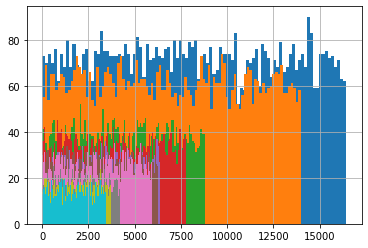

In [20]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Чтобы правильно интерпритировать данный показатель введем относительный ранг 'relative_rank':

In [21]:
data['relative_rank'] = data['Ranking'] / data['rest_counts']

Еще добавим параметр 'relative_rank_reviews' - ранг ресторана относительно количества отзывов о ресторанах в городе:

In [22]:
data['relative_rank_reviews'] = data['Ranking'] / data['reviews_in_city']

#### Price Range

Данный параметр отображает уровень цен в ресторане. Всего есть 3 категории цен и достаточно много пропущенных значений:

In [23]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Добавим на основе 'Price Range' новый признак 'restaurant_level' и заменим пропуски на самое популярное значение:

In [24]:
restaurant_level = []


for i in data['Price Range']:
    if i == '$':
        restaurant_level.append(1)
    elif i == '$$ - $$$':
        restaurant_level.append(2)
    elif i == '$$$$':
        restaurant_level.append(3)
    else:
        restaurant_level.append(2)

data['restaurant_level'] = restaurant_level

#### Number of Reviews

Признак содержит количество отзывов о ресторане и имеет небольшое количество пропусков, заполним их нулевыми значениями

In [25]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)

#### Reviews

Содержит данные(текст, время публикации) о 2 отзывах опубликованных на сайте ресторана.

Выделим даты публикации отзывов в отдельные признаки 'reviews_date_1', 'reviews_date_2'. Имеем достаточно много незаполненных значений. Заменим их на самую раннюю дату отзыва(чтобы не получить отрицательную разность при дальнейшей работе с признаками):

In [26]:
data['Reviews'] = data['Reviews'].fillna(0)

reviews_date = []
for i in data['Reviews']:
    if i == '[[], []]' or i == 0:
        reviews_date.append('')
    else:
        i = str(i).replace(']]', '')
        i = i.replace("'", '')
        i = i.split('], [')[1]
        i = i.split(', ')
        reviews_date.append(i)

data['reviews_date'] = reviews_date      
        
data['reviews_date_1'] = data['reviews_date'].apply(lambda x: x[1] if len(x) == 2 else None)
data['reviews_date_2'] = data['reviews_date'].apply(lambda x: x[0] if len(x) > 0 else None)

data['reviews_date_1'] = pd.to_datetime(data['reviews_date_1'])
data['reviews_date_2'] = pd.to_datetime(data['reviews_date_2'])

data['reviews_date_1'] = data['reviews_date_1'].apply(lambda x: data['reviews_date_1'].min()\
                                                      if pd.isnull(x) else x)
data['reviews_date_2'] = data['reviews_date_2'].apply(lambda x: data['reviews_date_1'].min()\
                                                      if pd.isnull(x) else x)

Создадим признак отображающий количество дней между оставленными на сайте отзывами:

In [27]:
data['between_dates'] = (data['reviews_date_2'] - data['reviews_date_1']).dt.days

Еще добавим признак показывающий сколько дней прошло с публикации последнего отзыва:

In [28]:
data['days_to_today'] = (datetime.now() - data['reviews_date_2']).dt.days

#### URL_TA 

Данный признак не несет никакой полезной для построения модели информации

#### ID_TA

Выделим из этого признака идентификатор ресторана:

In [29]:
data['id_ta'] = data['ID_TA'].apply(lambda x: int(x[1:]))

#### Категориальные признаки

Добавим dummy-признаки по столбцу 'City':

In [30]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

### Структура итогового датасета

Удалим все созданные для промежуточных прераций признаки, посмотрим на окончательную версию датасета и построим матрицу корреляции:

In [31]:
data = data.drop(['Restaurant_id', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'reviews_date_1', 
           'reviews_date_2', 'reviews_date'
                 ], axis = 1)


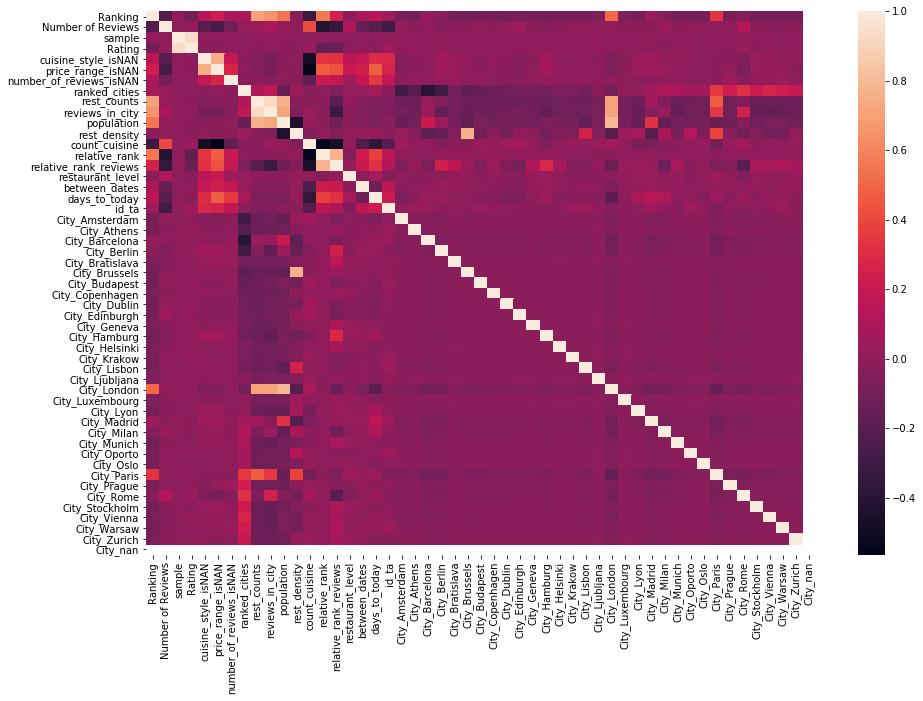

In [32]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(data.corr())

## Создание модели

In [33]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [34]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [35]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

In [36]:
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [37]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Округлим предсказанные значения до степени округления целевой переменной
y_pred = np.round(y_pred*2)/2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [38]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.162375


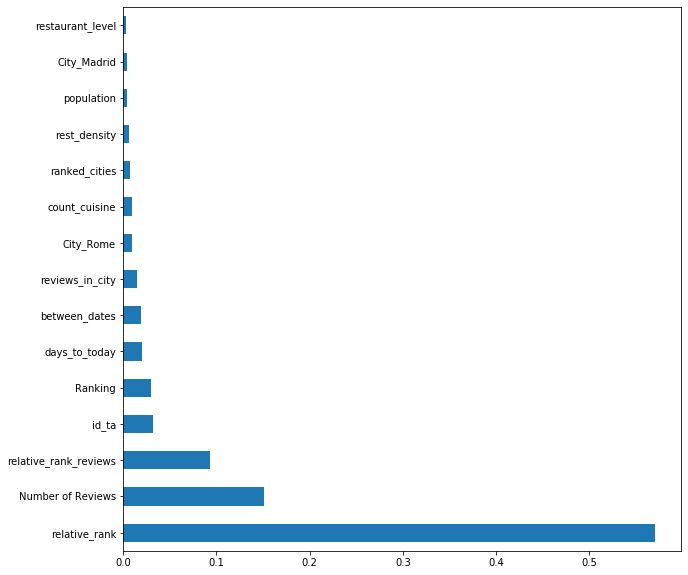

In [39]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Submission
Готовим Submission на кагл

In [40]:
test_data = test_data.drop(['Rating'], axis=1)

In [41]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [42]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [43]:
predict_submission = np.round(predict_submission*2)/2

In [44]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [45]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('data/submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
